In [1]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)


# Display the first few rows of the dataframe
print(data.head())

# Create a copy of the data
df = data.copy()

# Display column names
df.columns
df

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 48.2MB/s]


   Year  Month  Day  Inflation
0  2000      1   31   0.329139
1  2000      2   28   1.940367
2  2000      3   31   4.469678
3  2000      4   30   3.672022
4  2000      5   31   2.382412


,Year,Month,Day,Inflation
0,2000,1,31,0.329139
1,2000,2,28,1.940367
2,2000,3,31,4.469678
3,2000,4,30,3.672022
4,2000,5,31,2.382412
...,...,...,...,...
298,2024,11,30,-2.068252
299,2024,12,31,-1.742696
300,2025,1,31,-4.035874
301,2025,2,28,-4.187438


In [2]:
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)

            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


In [3]:
df

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [4]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 13.1 MB/s eta 0:00:00


In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import optuna


import numpy as np
import pandas as pd
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit


# Train-test split
train_size = int(len(df) * 0.7)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Use the target variable as inflation data (y)
y_train = train_data['Inflation']  # Replace with your actual column name if different
y_test = test_data['Inflation']

# Normalize the target using StandardScaler
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Prepare data for LSTM (create sequences)
def create_sequences(y_scaled, n_past, n_future):
    X, y_data = [], []
    for i in range(n_past, len(y_scaled) - n_future + 1):
        X.append(y_scaled[i - n_past:i, 0])
        y_data.append(y_scaled[i + n_future - 1:i + n_future, 0])
    return np.array(X), np.array(y_data)

# Objective function for Optuna
def objective(trial, y_train_scaled):
    n_past = trial.suggest_int("n_past", 1, 10)  # Time step size
    n_neurons = trial.suggest_int("n_neurons", 16, 128)
    n_layers = trial.suggest_int("n_layers", 1, 4)
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [1, 4, 8, 16, 32])
    optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"])
    epochs = trial.suggest_int("epochs", 10, 100)

    # Create sequences
    X, y_seq = create_sequences(y_train_scaled, n_past, 1)

    # Reshape input to (samples, time_steps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    mse_scores = []

    # TimeSeriesSplit cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y_seq[train_idx], y_seq[val_idx]

        # Build model
        model = Sequential()


        # First LSTM layer
        model.add(LSTM(n_neurons, return_sequences=(n_layers > 1), activation=activation,
                        input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))


        # Additional LSTM layers
        for i in range(1, n_layers):
            return_seq = (i < n_layers - 1)  # True for intermediate layers, False for last
            model.add(LSTM(n_neurons, return_sequences=return_seq, activation=activation))
            model.add(Dropout(dropout_rate))

        # Output layer
        model.add(Dense(1))

        # Compile model
        model.compile(optimizer=optimizer, loss="mean_squared_error")

        # Train model
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        # Predict and evaluate
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)

    return np.mean(mse_scores)

# Create and run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, y_train_scaled), n_trials=50)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)


[I 2025-05-29 04:30:31,530] A new study created in memory with name: no-name-d671a81c-ac9c-4154-87c3-9914c4f21469


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


[I 2025-05-29 04:31:22,672] Trial 0 finished with value: 0.2169377886343812 and parameters: {'n_past': 9, 'n_neurons': 81, 'n_layers': 2, 'activation': 'sigmoid', 'dropout_rate': 0.20166225534482246, 'batch_size': 16, 'optimizer': 'adam', 'epochs': 84}. Best is trial 0 with value: 0.2169377886343812.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step


[I 2025-05-29 04:34:48,042] Trial 1 finished with value: 0.5376917688182853 and parameters: {'n_past': 8, 'n_neurons': 98, 'n_layers': 3, 'activation': 'relu', 'dropout_rate': 0.33572260539127236, 'batch_size': 1, 'optimizer': 'sgd', 'epochs': 42}. Best is trial 0 with value: 0.2169377886343812.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 472ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 355ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step


[I 2025-05-29 04:36:25,691] Trial 2 finished with value: 0.8338794507253274 and parameters: {'n_past': 8, 'n_neurons': 114, 'n_layers': 4, 'activation': 'tanh', 'dropout_rate': 0.13072091643905256, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 82}. Best is trial 0 with value: 0.2169377886343812.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step


[I 2025-05-29 04:38:42,338] Trial 3 finished with value: 0.8164226137406564 and parameters: {'n_past': 10, 'n_neurons': 82, 'n_layers': 4, 'activation': 'relu', 'dropout_rate': 0.2065368332754242, 'batch_size': 4, 'optimizer': 'adam', 'epochs': 68}. Best is trial 0 with value: 0.2169377886343812.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


[I 2025-05-29 04:39:05,231] Trial 4 finished with value: 1.244615599055518 and parameters: {'n_past': 9, 'n_neurons': 118, 'n_layers': 2, 'activation': 'sigmoid', 'dropout_rate': 0.4484924835493568, 'batch_size': 4, 'optimizer': 'sgd', 'epochs': 15}. Best is trial 0 with value: 0.2169377886343812.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2025-05-29 04:40:08,401] Trial 5 finished with value: 0.11887399851551847 and parameters: {'n_past': 9, 'n_neurons': 93, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.19012222495270056, 'batch_size': 32, 'optimizer': 'rmsprop', 'epochs': 100}. Best is trial 5 with value: 0.11887399851551847.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


[I 2025-05-29 04:40:25,639] Trial 6 finished with value: 0.2593456068176268 and parameters: {'n_past': 8, 'n_neurons': 119, 'n_layers': 1, 'activation': 'sigmoid', 'dropout_rate': 0.2787875814733667, 'batch_size': 8, 'optimizer': 'rmsprop', 'epochs': 24}. Best is trial 5 with value: 0.11887399851551847.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


[I 2025-05-29 04:40:33,999] Trial 7 finished with value: 0.6766021258101553 and parameters: {'n_past': 2, 'n_neurons': 82, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.38877051146261554, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 15}. Best is trial 5 with value: 0.11887399851551847.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


[I 2025-05-29 04:41:13,017] Trial 8 finished with value: 0.33417481262156906 and parameters: {'n_past': 4, 'n_neurons': 74, 'n_layers': 2, 'activation': 'sigmoid', 'dropout_rate': 0.2848391504339938, 'batch_size': 4, 'optimizer': 'rmsprop', 'epochs': 44}. Best is trial 5 with value: 0.11887399851551847.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


[I 2025-05-29 04:41:56,388] Trial 9 finished with value: 0.23341583637484847 and parameters: {'n_past': 3, 'n_neurons': 93, 'n_layers': 2, 'activation': 'tanh', 'dropout_rate': 0.1703674860062109, 'batch_size': 1, 'optimizer': 'sgd', 'epochs': 17}. Best is trial 5 with value: 0.11887399851551847.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


[I 2025-05-29 04:42:40,457] Trial 10 finished with value: 0.24429476808596115 and parameters: {'n_past': 6, 'n_neurons': 44, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.24330564528254264, 'batch_size': 32, 'optimizer': 'rmsprop', 'epochs': 100}. Best is trial 5 with value: 0.11887399851551847.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


[I 2025-05-29 04:43:35,922] Trial 11 finished with value: 0.20336793897873587 and parameters: {'n_past': 6, 'n_neurons': 54, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.10893682284246076, 'batch_size': 16, 'optimizer': 'adam', 'epochs': 100}. Best is trial 5 with value: 0.11887399851551847.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-05-29 04:44:27,459] Trial 12 finished with value: 0.1730626365108673 and parameters: {'n_past': 5, 'n_neurons': 51, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.10920413314261405, 'batch_size': 32, 'optimizer': 'adam', 'epochs': 100}. Best is trial 5 with value: 0.11887399851551847.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step


[I 2025-05-29 04:45:21,821] Trial 13 finished with value: 0.3833031753365316 and parameters: {'n_past': 5, 'n_neurons': 19, 'n_layers': 4, 'activation': 'tanh', 'dropout_rate': 0.14862247380643984, 'batch_size': 32, 'optimizer': 'adam', 'epochs': 83}. Best is trial 5 with value: 0.11887399851551847.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step


[I 2025-05-29 04:45:54,833] Trial 14 finished with value: 0.13338065655833825 and parameters: {'n_past': 1, 'n_neurons': 54, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.11085070737523826, 'batch_size': 32, 'optimizer': 'rmsprop', 'epochs': 67}. Best is trial 5 with value: 0.11887399851551847.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2025-05-29 04:46:26,768] Trial 15 finished with value: 0.17421692488359797 and parameters: {'n_past': 1, 'n_neurons': 34, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.19721378492683264, 'batch_size': 32, 'optimizer': 'rmsprop', 'epochs': 65}. Best is trial 5 with value: 0.11887399851551847.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step


[I 2025-05-29 04:47:05,337] Trial 16 finished with value: 0.22225365173800057 and parameters: {'n_past': 1, 'n_neurons': 60, 'n_layers': 4, 'activation': 'tanh', 'dropout_rate': 0.34879883493957575, 'batch_size': 32, 'optimizer': 'rmsprop', 'epochs': 54}. Best is trial 5 with value: 0.11887399851551847.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


[I 2025-05-29 04:47:46,039] Trial 17 finished with value: 0.23649005824880912 and parameters: {'n_past': 7, 'n_neurons': 65, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.24159431783146745, 'batch_size': 32, 'optimizer': 'rmsprop', 'epochs': 70}. Best is trial 5 with value: 0.11887399851551847.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


[I 2025-05-29 04:48:12,533] Trial 18 finished with value: 0.19125320053601488 and parameters: {'n_past': 3, 'n_neurons': 96, 'n_layers': 2, 'activation': 'tanh', 'dropout_rate': 0.15438896913917452, 'batch_size': 32, 'optimizer': 'rmsprop', 'epochs': 36}. Best is trial 5 with value: 0.11887399851551847.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step


[I 2025-05-29 04:49:11,578] Trial 19 finished with value: 2.676434073751134 and parameters: {'n_past': 10, 'n_neurons': 33, 'n_layers': 4, 'activation': 'relu', 'dropout_rate': 0.48484887647152664, 'batch_size': 32, 'optimizer': 'rmsprop', 'epochs': 89}. Best is trial 5 with value: 0.11887399851551847.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


[I 2025-05-29 04:49:49,173] Trial 20 finished with value: 0.11475090476096919 and parameters: {'n_past': 3, 'n_neurons': 109, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.24238144905852732, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 56}. Best is trial 20 with value: 0.11475090476096919.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step


[I 2025-05-29 04:50:27,734] Trial 21 finished with value: 0.14163871382843207 and parameters: {'n_past': 2, 'n_neurons': 106, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.21553920371571023, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 56}. Best is trial 20 with value: 0.11475090476096919.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2025-05-29 04:51:09,661] Trial 22 finished with value: 0.09927627927461677 and parameters: {'n_past': 3, 'n_neurons': 125, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.2565972288045767, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 55}. Best is trial 22 with value: 0.09927627927461677.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2025-05-29 04:51:39,645] Trial 23 finished with value: 0.22776564072909067 and parameters: {'n_past': 4, 'n_neurons': 107, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.25428528833988273, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 32}. Best is trial 22 with value: 0.09927627927461677.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


[I 2025-05-29 04:52:13,991] Trial 24 finished with value: 0.09213755660387338 and parameters: {'n_past': 4, 'n_neurons': 128, 'n_layers': 2, 'activation': 'tanh', 'dropout_rate': 0.2892975941194973, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 53}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


[I 2025-05-29 04:52:35,308] Trial 25 finished with value: 0.10310567363692882 and parameters: {'n_past': 3, 'n_neurons': 128, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.32096390871462444, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 52}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


[I 2025-05-29 04:52:55,815] Trial 26 finished with value: 0.09675004273528996 and parameters: {'n_past': 4, 'n_neurons': 128, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.3248210703717314, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 48}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


[I 2025-05-29 04:53:20,669] Trial 27 finished with value: 0.10906406900348802 and parameters: {'n_past': 4, 'n_neurons': 128, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.37140407300211786, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 47}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


[I 2025-05-29 04:53:45,134] Trial 28 finished with value: 0.1306910899318858 and parameters: {'n_past': 5, 'n_neurons': 120, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.39851246023255615, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 62}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


[I 2025-05-29 04:54:07,119] Trial 29 finished with value: 0.7012842608212473 and parameters: {'n_past': 2, 'n_neurons': 124, 'n_layers': 2, 'activation': 'sigmoid', 'dropout_rate': 0.30697092562771183, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 32}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


[I 2025-05-29 04:54:46,733] Trial 30 finished with value: 0.23779555192745033 and parameters: {'n_past': 4, 'n_neurons': 111, 'n_layers': 2, 'activation': 'sigmoid', 'dropout_rate': 0.274621440749585, 'batch_size': 16, 'optimizer': 'adam', 'epochs': 76}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


[I 2025-05-29 04:55:05,043] Trial 31 finished with value: 0.10728126954214331 and parameters: {'n_past': 3, 'n_neurons': 120, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.3201195051376194, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 51}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


[I 2025-05-29 04:55:22,209] Trial 32 finished with value: 0.11450671339226497 and parameters: {'n_past': 4, 'n_neurons': 127, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.33203879700977523, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 39}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


[I 2025-05-29 04:56:22,919] Trial 33 finished with value: 0.10499066470018466 and parameters: {'n_past': 2, 'n_neurons': 102, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.36123871965217025, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 48}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


[I 2025-05-29 04:56:42,496] Trial 34 finished with value: 0.15801342294616522 and parameters: {'n_past': 3, 'n_neurons': 114, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.29838708715653545, 'batch_size': 16, 'optimizer': 'sgd', 'epochs': 60}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


[I 2025-05-29 04:57:27,487] Trial 35 finished with value: 0.16663884119394706 and parameters: {'n_past': 5, 'n_neurons': 128, 'n_layers': 2, 'activation': 'relu', 'dropout_rate': 0.4043651686928149, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 74}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


[I 2025-05-29 04:58:03,838] Trial 36 finished with value: 0.13524158510534362 and parameters: {'n_past': 6, 'n_neurons': 115, 'n_layers': 2, 'activation': 'tanh', 'dropout_rate': 0.32751012529650836, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 45}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


[I 2025-05-29 04:58:38,936] Trial 37 finished with value: 0.14539623185332576 and parameters: {'n_past': 4, 'n_neurons': 122, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.2612488076096517, 'batch_size': 4, 'optimizer': 'sgd', 'epochs': 60}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


[I 2025-05-29 04:58:59,686] Trial 38 finished with value: 0.1566613684367257 and parameters: {'n_past': 3, 'n_neurons': 88, 'n_layers': 1, 'activation': 'sigmoid', 'dropout_rate': 0.3020964676868066, 'batch_size': 8, 'optimizer': 'rmsprop', 'epochs': 40}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


[I 2025-05-29 05:00:57,692] Trial 39 finished with value: 0.1260719592094731 and parameters: {'n_past': 2, 'n_neurons': 101, 'n_layers': 2, 'activation': 'relu', 'dropout_rate': 0.42380291395443853, 'batch_size': 1, 'optimizer': 'adam', 'epochs': 52}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


[I 2025-05-29 05:01:12,560] Trial 40 finished with value: 0.1508113811897085 and parameters: {'n_past': 5, 'n_neurons': 116, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.22148995846186526, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 26}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


[I 2025-05-29 05:02:19,355] Trial 41 finished with value: 0.11170145548874182 and parameters: {'n_past': 2, 'n_neurons': 102, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.3611670681831725, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 48}. Best is trial 24 with value: 0.09213755660387338.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


[I 2025-05-29 05:03:38,698] Trial 42 finished with value: 0.08835284945697189 and parameters: {'n_past': 3, 'n_neurons': 123, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.3552982646726924, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 49}. Best is trial 42 with value: 0.08835284945697189.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


[I 2025-05-29 05:04:48,658] Trial 43 finished with value: 0.08659367423943157 and parameters: {'n_past': 3, 'n_neurons': 123, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.3434036115006897, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 42}. Best is trial 43 with value: 0.08659367423943157.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


[I 2025-05-29 05:06:48,477] Trial 44 finished with value: 0.23656732032780411 and parameters: {'n_past': 4, 'n_neurons': 122, 'n_layers': 2, 'activation': 'tanh', 'dropout_rate': 0.34369720124607306, 'batch_size': 1, 'optimizer': 'sgd', 'epochs': 42}. Best is trial 43 with value: 0.08659367423943157.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


[I 2025-05-29 05:07:49,075] Trial 45 finished with value: 0.09350930748227007 and parameters: {'n_past': 4, 'n_neurons': 112, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.3851400930582021, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 32}. Best is trial 43 with value: 0.08659367423943157.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


[I 2025-05-29 05:08:46,251] Trial 46 finished with value: 0.08960146854680624 and parameters: {'n_past': 7, 'n_neurons': 112, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.3799682896347059, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 25}. Best is trial 43 with value: 0.08659367423943157.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


[I 2025-05-29 05:09:13,399] Trial 47 finished with value: 0.19956346396615104 and parameters: {'n_past': 7, 'n_neurons': 112, 'n_layers': 1, 'activation': 'sigmoid', 'dropout_rate': 0.4222745895929059, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 10}. Best is trial 43 with value: 0.08659367423943157.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


[I 2025-05-29 05:10:05,572] Trial 48 finished with value: 0.12362601804596118 and parameters: {'n_past': 7, 'n_neurons': 89, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.3770646420598261, 'batch_size': 1, 'optimizer': 'adam', 'epochs': 23}. Best is trial 43 with value: 0.08659367423943157.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


[I 2025-05-29 05:11:10,605] Trial 49 finished with value: 0.11042151364467585 and parameters: {'n_past': 8, 'n_neurons': 118, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.44926527794521093, 'batch_size': 1, 'optimizer': 'sgd', 'epochs': 29}. Best is trial 43 with value: 0.08659367423943157.


Best Hyperparameters: {'n_past': 3, 'n_neurons': 123, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.3434036115006897, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 42}


Best Hyperparameters: {'n_past': 3, 'n_neurons': 123, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.3434036115006897, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 42}
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
RMSE: 4.696858476508521
MSE: 22.060479548349946
MAE: 2.5104283054811964
MAPE: 39.128703826615556
R-squared: 0.9337718279955036


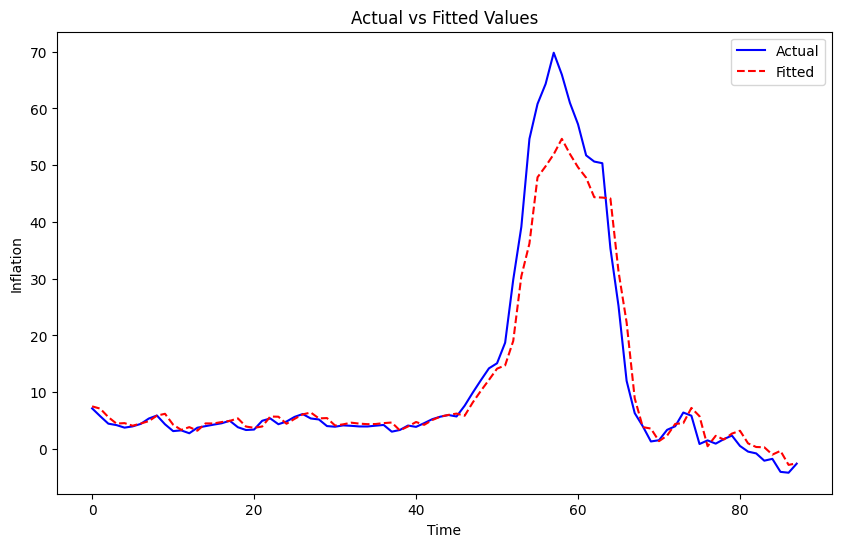

In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import optuna

# Best hyperparameters found
print("Best Hyperparameters:", study.best_params)

# Using the best hyperparameters to train the model
best_params = study.best_params
n_past = best_params["n_past"]
n_neurons = best_params["n_neurons"]
n_layers = best_params["n_layers"]
activation = best_params["activation"]
dropout_rate = best_params["dropout_rate"]
batch_size = best_params["batch_size"]
optimizer = best_params["optimizer"]
epochs = best_params["epochs"]

# Create sequences with the chosen time step size (window size)
X_train, y_train = create_sequences(y_train_scaled, n_past, 1)
X_test, y_test = create_sequences(y_test_scaled, n_past, 1)

# Build the LSTM model with the best parameters
model = Sequential()

# First LSTM layer
model.add(LSTM(n_neurons, return_sequences=(n_layers > 1), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_rate))

# Additional LSTM layers
for _ in range(n_layers - 1):
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dropout(dropout_rate))

# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer=optimizer, loss="mean_squared_error")

# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

# Predict on test set
y_pred_scaled = model.predict(X_test)

# Inverse transform to get the actual predicted values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate performance metrics
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, y_pred)

# Print the results
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R-squared: {r2}")

# Plot actual vs fitted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label="Actual", color='blue')
plt.plot(y_pred, label="Fitted", color='red', linestyle='--')
plt.title('Actual vs Fitted Values')
plt.xlabel('Time')
plt.ylabel('Inflation')
plt.legend()
plt.show()
